# AI Makerspace - Unsloth GRPO Training

In this notebook, we will use the work done by Unsloth to walk through a small scale sample of the DeepSeek-R1 process outlined in their paper.

This is not a direct 1-to-1, but it does outline the major innovations in the paper.

Let's dive in!

### What is the GRPO Training Process with RL?

1. Group Sampling: For a single prompt or state, the policy generates a batch of outputs (instead of just one). This produces a small “group” of possible actions or answers.

2. Reward Scoring: Each output is scored by a reward function, which reflects how good or desirable that output is for the task at hand.

3. Group-Based Advantage: The algorithm calculates each output’s “advantage” by comparing its reward to the average reward of the entire group. If the output’s reward is above average, it has a positive advantage (and vice versa).

4. Policy Update: The policy is adjusted to promote outputs with a positive advantage and discourage those with a negative advantage. A KL penalty term prevents the policy from changing too drastically.

5. Iterative Process: The updated policy is used again to generate new groups, score them, and update—repeating until the policy converges or meets performance goals.

This group-based approach removes the need for a separate value function (critic) and helps the policy quickly learn which outputs are relatively better within each sampled group.

# 🤝 BREAKOUT ROOM #1

> NOTE: A lot of the cells will take 1min. or more to run. This is expected!

### Overview of PEFT and LoRA:

Based on some awesome research [here](https://github.com/huggingface/peft), we can leverage techniques like PEFT and LoRA to train/fine-tune large models a lot more efficiently.

It can't be explained much better than the overview given in the above link:

```
Parameter-Efficient Fine-Tuning (PEFT) methods enable efficient adaptation of
pre-trained language models (PLMs) to various downstream applications without
fine-tuning all the model's parameters. Fine-tuning large-scale PLMs is often
prohibitively costly. In this regard, PEFT methods only fine-tune a small
number of (extra) model parameters, thereby greatly decreasing the
computational and storage costs. Recent State-of-the-Art PEFT techniques
achieve performance comparable to that of full fine-tuning.
```

### Installation

As you can see, we'll only need a few dependencies thanks to the collective hard work of the community!

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm==0.7.3
else:
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    !pip install --no-deps unsloth vllm==0.7.3

In [ ]:
#@title Colab Extra Install { display-mode: "form" }
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    !pip install --no-deps unsloth vllm
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    # Skip restarting message in Colab
    import sys, re, requests; modules = list(sys.modules.keys())
    for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft "trl==0.15.2" triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer

    # vLLM requirements - vLLM breaks Colab due to reinstalling numpy
    f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
    with open("vllm_requirements.txt", "wb") as file:
        file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
    !pip install -r vllm_requirements.txt

## Task #1: Loading the Model

In the following task you will be expected to load the model from Hugging Face.

### Overview of Quantization:

Quantization is ultimately a simple concept with some very clever and tricky techniques that power it.

In today's notebook, we'll be exclusively focusing on the `bitsandbytes` quantization strategy which includes the idea of `k-bit` training.

Let's look at the QLoRA paper's definition of quantization:


```
Quantization is the process of discretizing an input from a representation that
holds more information to a representation with less information
```

Easy enough then!

Let's take a look at what that actually means.

### Block-wise k-bit Quantization

Ultimately, the QLoRA paper relies on a very specific form of quantization that relies on a few key ideas:

1. Model weights are mostly normally distributed
2. NF4 is a information-theoretically optimal data-type (this was later found to be [untrue](https://x.com/Tim_Dettmers/status/1668649436724199425?s=20), but NF4 is close to *empirically* optimal)


Let's think about quantization from a very high level - and use some oversimplifications to understand what's really happening under the hood.

In essence, we can think of quantization as placing a pin on the number line (our quantization constant) and then expressing a low-precision zero-centered size-64 block range around that pinned number. Exploiting the fact that our weights are normally distributed and that we scale them to be in the range [-1, 1], this lets use use our NF4 datatype to roughly optimally express our high precision weights in a low precision format. While we still do need *some* higher precision numbers - this process lets use represent many numbers in low precision for the cost of 1 number in high precision.

However, we can take it one step further - and we can actually quantize the range of quantization constants we wind up with as well! This winds up saving us ~0.373 bits per parameter.

#### Initializing LoRA Config

There's a lot to unpack here - so let's talk about the main parameters:

- `r`: is the "rank" of the two decomposed matrices we'll be using to represent our weight matrix. In reality, this is the dimension of the decomposed matrices.

Here is an exerpt from the paper to help provide context for the selected `r`

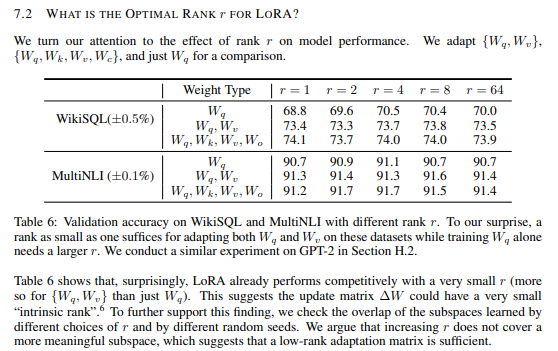


- `target_modules`: As LoRA can be applied to *any* weight matrix - we need to configure *which* module (weight matrix) it's being applied to. The LoRA paper suggests applying it to the Attention weights, but the QLoRA paper suggests we apply it to all Linear layers. Thus, we'll omit `target_module` from our hyper-parameters.


- `task_type`: This is a derived property. If you're using a causal model, this should be set to `CAUSAL_LM`. Please ensure this property is set based on your selected model.

Again, while this is the way we're leveraging LoRA in this notebook - it can be used in conjunction with many different models - and many different tasks. You can even use it for tasks like [token classification!](https://huggingface.co/docs/peft/task_guides/token-classification-lora)

Leveraging the work done in [QLoRA](https://arxiv.org/pdf/2305.14314.pdf) means we need to set some specific hyper-parameters for our [`quantization_config`](https://github.com/huggingface/transformers/blob/2fc33ebead50383f7707b17f0e2a178d86347d10/src/transformers/utils/quantization_config.py#L151).

- `load_in_4bit` - we'll want to set this to true so we can load and train our model on a single 16GB GPU.



In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "meta-llama/Llama-3.2-3B-Instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = False, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.7, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ], # Remove QKVO if out of memory
    lora_alpha = lora_rank,
    use_gradient_checkpointing = "unsloth", # Enable long context finetuning
    random_state = 3407,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 05-04 10:28:09 __init__.py:207] Automatically detected platform cuda.
==((====))==  Unsloth 2025.4.7: Fast Llama patching. Transformers: 4.51.3. vLLM: 0.7.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/llama-3.2-3b-instruct-unsloth-bnb-4bit with actual GPU utilization = 69.2%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 320.
Unsloth: vLLM's KV Cache can use up to

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

INFO 05-04 10:28:30 cuda.py:229] Using Flash Attention backend.
INFO 05-04 10:28:30 model_runner.py:1110] Starting to load model unsloth/llama-3.2-3b-instruct-unsloth-bnb-4bit...
INFO 05-04 10:28:30 loader.py:1089] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 05-04 10:28:31 weight_utils.py:254] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

INFO 05-04 10:29:04 weight_utils.py:270] Time spent downloading weights for unsloth/llama-3.2-3b-instruct-unsloth-bnb-4bit: 33.112207 seconds


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 05-04 10:29:06 model_runner.py:1115] Loading model weights took 2.2405 GB
INFO 05-04 10:29:06 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 05-04 10:29:15 worker.py:267] Memory profiling takes 8.72 seconds
INFO 05-04 10:29:15 worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.69) = 27.37GiB
INFO 05-04 10:29:15 worker.py:267] model weights take 2.24GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 1.49GiB; the rest of the memory reserved for KV Cache is 23.55GiB.
INFO 05-04 10:29:16 executor_base.py:111] # cuda blocks: 13781, # CPU blocks: 3510
INFO 05-04 10:29:16 executor_base.py:116] Maximum concurrency for 2048 tokens per request: 107.66x
INFO 05-04 10:29:19 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error

Capturing CUDA graph shapes: 100%|██████████| 43/43 [00:57<00:00,  1.34s/it]

INFO 05-04 10:30:17 model_runner.py:1562] Graph capturing finished in 58 secs, took 0.75 GiB
INFO 05-04 10:30:17 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 70.69 seconds


tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

Unsloth 2025.4.7 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
        (layers): ModuleList(
          (0): LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(
  

In [ ]:
model.config

LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 24,
  "num_hidden_layers": 28,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "quantization_config": {
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_

#### ❓Question #1:

What exactly is happening in the double quantization step?

> NOTE: You can use the paper provided to find the answer!


In **QLoRA** paper, *Double Quantisation* is a memory-saving trick that helps store the quantized weights more efficiently. What it does:

1. **First Quantisation (4-bit NF4)**:

   * The model weights are quantized to **4 bits** using **NF4 (Normalized Float 4)** format. This already reduces memory significantly (from FP16/32 down to 4 bits).

2. **Second Quantisation = Quantising the Quantisers**:

   * Instead of storing a separate scale and zero point **for every weight block**, QLoRA **quantizes the quantisation parameters** themselves.
   * That is: **quantise the quantiser metadata** (e.g., the per-group scales).


This reduces memory usage by **0.37 bits per parameter**, on average. This adds up to big savings when dealing with billions of parameters.

---

In the model config:

```json
"quantization_config": {
  "bnb_4bit_quant_type": "nf4",
  "bnb_4bit_use_double_quant": true,
  ...
}
```

That means:

* The model uses **NF4 quantization** (first quantisation).
* `bnb_4bit_use_double_quant: true` = **Double Quantisation is enabled**, per QLoRA.

So:

* We're storing the model in **4-bit compressed format**
* We're also **compressing the quantisation metadata** for additional efficiency
* This config directly implements the key optimsation in the QLoRA paper

#### ❓Question #2:

![image](https://i.imgur.com/N8y2crZ.png)

Label the image with the appropriate layer from `meta-llama/Llama-3.2-3B-Instruct`'s architecture.

- EXAMPLE - Layer Norm:
  - `(input_layernorm): LlamaRMSNorm()`
  - `(post_attention_layernorm): LlamaRMSNorm()`
  - `(norm): LlamaRMSNorm()`
- Feed Forward:
- Masked Multi Self-Attention:
- Text & Position Embed:
- Text Prediction:
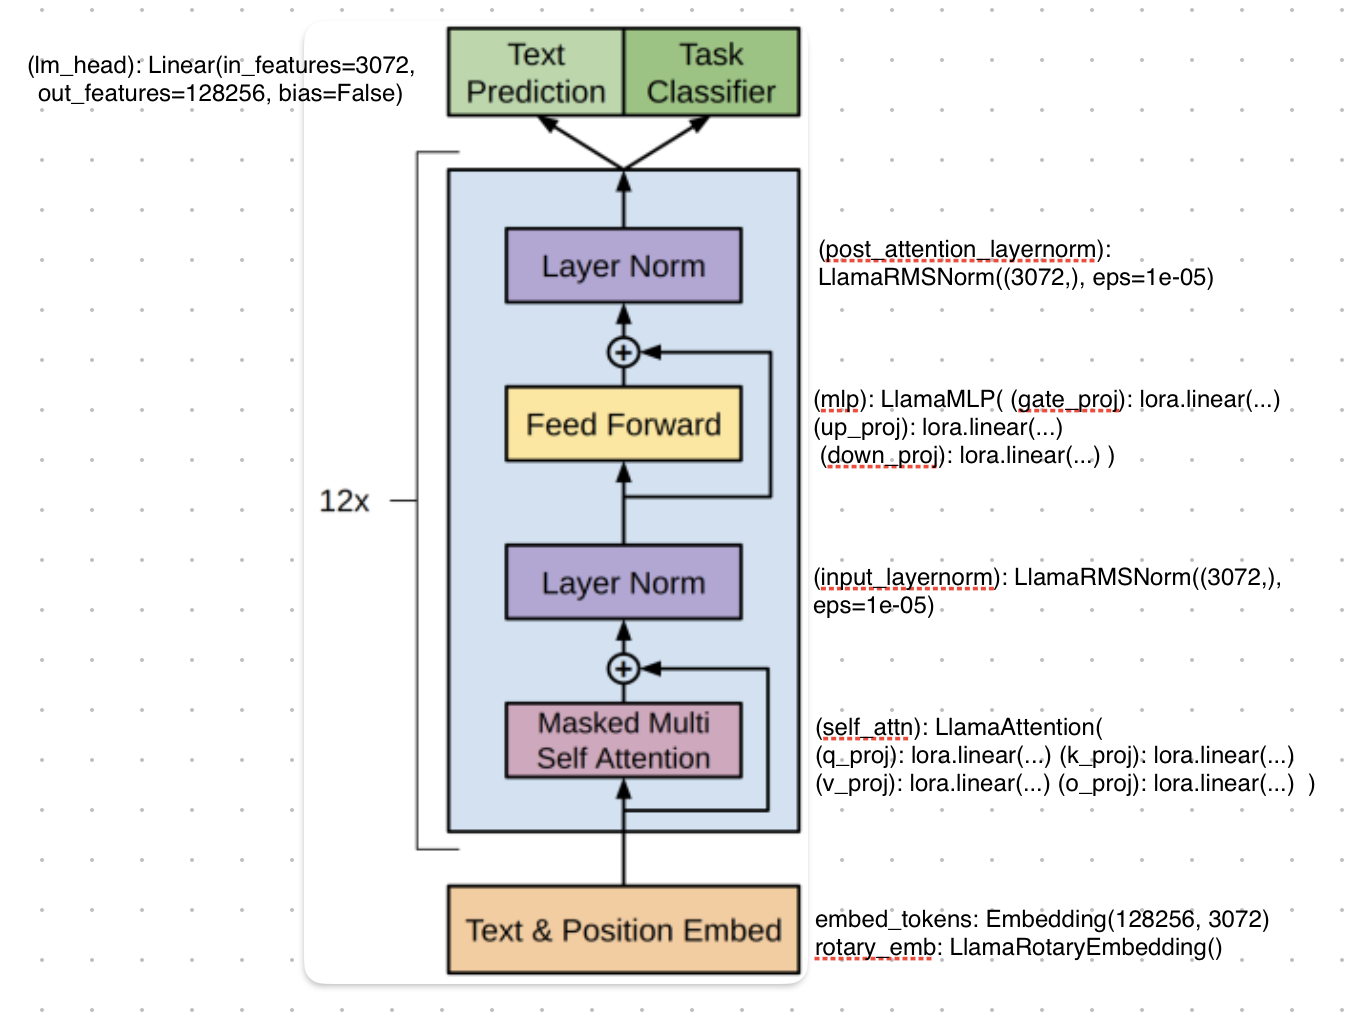

#### ❓Question #3:

What, in your own words, is LoRA doing?

In simple terms, LoRA (Low-Rank Adaptation) is a technique that makes it faster and cheaper to fine-tune large language models like LLaMA without changing their original weights.

# 🤝 BREAKOUT ROOM #2

### Data Preparation

You'll notice a peculiarity here - our dataset is just...inputs and outputs! (specifically from the GSM8K data).

But wait, we said this was different from SFT - but this is seemingly just SFT all over again!

Well, we still need questions and answers to verify that we're learning *something* productive - but importantly, we are not leveraging a specific human preference reward model, or process reward model to bake our responses into the model - we just need a way to verify if an answer provided by our model was correct or incorrect. A way, to *reward* correct generations!

For now, let's examine what our input data looks like.

> NOTE: Unsloth directly leveraged the work that [@willccbb](https://gist.github.com/willccbb/4676755236bb08cab5f4e54a0475d6fb) did, for data prep and all reward functions.

In [ ]:
import re
from datasets import load_dataset, Dataset

# This string defines the instructions for formatting responses.
# Responses should include two parts: reasoning and answer, each wrapped in XML-like tags.
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

# This template provides a way to format the response with placeholders for reasoning and answer.
XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

def extract_xml_answer(text: str) -> str:
    """
    Extracts and returns the text between the <answer> and </answer> tags.

    Steps:
    1. Splits the input text at the <answer> tag and takes the last part.
    2. Splits the result at the </answer> tag.
    3. Strips any extra whitespace and returns the cleaned answer.
    """
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

def extract_hash_answer(text: str) -> str | None:
    """
    Looks for the marker '####' in the input text.

    If found:
    - Splits the text on '####' and returns the portion after the marker, stripped of whitespace.
    If not found:
    - Returns None.
    """
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

# uncomment middle messages for 1-shot prompting
def get_gsm8k_questions(split = "train") -> Dataset:
    """
    Loads the GSM8K dataset (grade school math problems) and processes each item.

    For each problem in the dataset:
    1. Creates a prompt with two messages:
       - A system message containing the response formatting instructions.
       - A user message containing the question.
    2. Extracts the answer using the 'extract_hash_answer' function.

    Returns:
        The processed dataset with each entry containing the formatted prompt and extracted answer.
    """
    data = load_dataset('openai/gsm8k', 'main')[split] # type: ignore
    data = data.map(lambda x: { # type: ignore
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    }) # type: ignore
    return data # type: ignore

dataset = get_gsm8k_questions()

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

As you can see in this data, there is no specific information about preference, or "how to reason", or anything close to it. It's simply the question and the answer.

This is the core idea behind this style of training - we're not going to give the model *how* to think as an example - we're simply going to let it play in a sandbox defined by the question and answer.

> NOTE: This is not the case for DeepSeek-R1, where there is a *very small* amount of SFT that occurs (called the "cold-start") to "prime" the model for the subsequent RL stage of training.

In [ ]:
dataset[0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': '72',
 'prompt': [{'content': '\nRespond in the following format:\n<reasoning>\n...\n</reasoning>\n<answer>\n...\n</answer>\n',
   'role': 'system'},
  {'content': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
   'role': 'user'}]}

Now we get to the *magic* of the approach - a collection of reward models.

Notice that we have a number of different "checks" we do - these come together as expressed in the following diagram:

![image](https://i.imgur.com/7Dp0qdt.png)

What this means, essentially, is that we use a suite of reward functions to determine if our model is learning "how we want", as opposed to giving it examples that show it how we want it to learn.

These reward functions are totally customizable - and allow users to effectively steer how and what the model is incentivized to "get good at".

In [ ]:
# Reward functions
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    """
    This function evaluates the correctness of the model's response.

    Steps:
    - It extracts the content of the first message from each completion.
    - It then extracts the answer from the XML-formatted response using the extract_xml_answer function.
    - For debugging, it prints the original question, the expected answer, the raw response, and the extracted answer.
    - Finally, it compares the extracted response to the expected answer and assigns a reward of 2.0 if they are equal, otherwise 0.0.
    """
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

def int_reward_func(completions, **kwargs) -> list[float]:
    """
    This function rewards responses that are purely numeric.

    Steps:
    - It extracts the content of the first message from each completion.
    - It extracts the answer from the XML-formatted response.
    - It checks if the extracted answer is a digit (i.e., a numeric string) and returns a reward of 0.5 if it is, otherwise 0.0.
    """
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """
    This function rewards responses that exactly follow a strict XML format.

    Steps:
    - It uses a regular expression pattern that enforces the precise structure:
      The response must start with <reasoning> on its own line, followed by some text,
      then </reasoning> on its own line, then <answer> on its own line, some text,
      and finally </answer> on its own line, with no extra content before or after.
    - It returns a reward of 0.5 if the response exactly matches this pattern, otherwise 0.0.
    """
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """
    This function rewards responses that generally follow the expected XML format.

    Steps:
    - It uses a more relaxed regular expression pattern that checks for the presence of <reasoning> and </reasoning>
      followed by <answer> and </answer> somewhere in the text.
    - It returns a reward of 0.5 if the pattern is found, otherwise 0.0.
    """
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def count_xml(text) -> float:
    """
    This helper function calculates a reward score based on the presence and exact count
    of specific XML formatting markers in the text.

    Steps:
    - It checks if the text contains exactly one occurrence of each of the tags with newlines:
      "<reasoning>\n", "\n</reasoning>\n", "\n<answer>\n", and "\n</answer>".
    - It adds 0.125 to the count for each correctly placed tag.
    - For the <answer> and </answer> tags, it subtracts a small penalty based on the length of the text
      following the closing tags.
    - Returns the total score.
    """
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    """
    This function applies the count_xml helper function to each completion.

    Steps:
    - It extracts the content of the first message from each completion.
    - It computes a reward score for each response by counting the XML formatting elements using count_xml.
    - Returns a list of reward scores.
    """
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

In [ ]:
soft_format_reward_func([[{"content" : "<reasoning>Wow, cool!</reasoning><answer>23</answer>"}]])

[0.5]

In [ ]:
max_prompt_length = max(dataset.map(
    lambda x: {"tokens" : tokenizer.apply_chat_template(x["prompt"], add_generation_prompt = True, tokenize = True)},
    batched = True,
).map(lambda x: {"length" : len(x["tokens"])})["length"])

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

### Train the model

All that is left to do, now that we have our:

1. Training examples
2. Reward Functions

Is to train our model!

We'll start with setting a number of hyper-parameters.

> NOTE: These hyper-parameters are based around the free-tier Colab T4 instance, you can modify them to "right size" to your hardware.

### GPROConfig

First and foremost - we have a number of typical hyper-parameters (as always).

You'll also notice a distinct *lack* of GRPO hyper-parameters being used in this implementation - we'll stick with the defaults to keep this notebook manageable, but you're welcome to dive deep into TRL and play around to see what works best for your use-case.

> NOTE: If you wish to walk away with the classic "RL" image of "line going up to the right", you can remove the `report_to = "none"` from the following config.This will require you to have a Weights and Biases API key - which you can get by following [this](https://docs.wandb.ai/quickstart/) process.

In [ ]:
max_prompt_length = max_prompt_length + 1 # + 1 just in case!

from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    learning_rate = 5e-6,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "adamw_torch_fused",
    logging_steps = 1,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 4, # Increase to 4 for smoother training
    num_generations = 8, # Decrease if out of memory
    max_prompt_length = max_prompt_length,
    max_completion_length = max_seq_length - max_prompt_length,
    # num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 175,
    save_steps = 25,
    max_grad_norm = 0.1,
    report_to = "wandb", # Can use Weights & Biases
    output_dir = "outputs",
)

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 8


#### ❓Question #4:

Describe what the following parameters are doing:

- `warmup_ratio`
- `learning_rate`
- `lr_scheduler_type`

**warmup_ratio = 0.1**
* What it does: Gradually increases the learning rate from 0 to the set learning_rate over the first 10% of training steps (since 0.1 = 10%).

* Why it matters: This "warm-up" helps stabilize training early on, especially when fine-tuning large language models, avoiding sudden large updates that could destabilize the model weights.
Think of it as easing into learning before hitting full stride.

**learning_rate = 5e-6**
* What it does: Sets the maximum step size for weight updates during optimization (after warmup).

* Why it matters: A smaller value like 5e-6 is common for fine-tuning LLMs to avoid overwriting pre-trained knowledge.
Too high → unstable training; too low → very slow learning.
This is the main hyperparameter controlling how much the model learns from each training step.

**lr_scheduler_type = "cosine"**
* What it does: Defines the shape of the learning rate decay schedule. Cosine decay gradually reduces the learning rate following a cosine curve: Starts at learning_rate. Drops slowly at first. Then rapidly approaches zero near the end of training

* Why it matters: This strategy balances exploration early with fine-tuning at the end, which often helps achieve smoother convergence. Cosine decay is like easing off the gas pedal gradually, with more precision toward the finish.



> NOTE: Feel free to consult the [documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) or other resources!

Finally, we can run our trainer!

The basic idea in this RL focused approach is that, instead of watching loss go down, we want to watch reward *go up!*.

> NOTE: The training has a kind of "Aha!" moment, as it's been described, whereby the reward goes from ~0 and then suddenly begins increasing. This is expected behaviour - but you may not see changes in the reward column (the combined output of our above define reward functions) until you get past the 100th-150th step.

In [ ]:
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func,
    ],
    args = training_args,
    train_dataset = dataset,
)
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 7,473 | Num Epochs = 1 | Total steps = 175
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 4 x 1) = 32
 "-____-"     Trainable parameters = 97,255,424/3,000,000,000 (3.24% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jkeatnuxsuo (jkeatnuxsuo-ai-makerspace) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,reward,reward_std,completion_length,kl,rewards / xmlcount_reward_func,rewards / soft_format_reward_func,rewards / strict_format_reward_func,rewards / int_reward_func,rewards / correctness_reward_func
1,0.000000,-0.216781,0.597230,268.000000,0.000000,-0.373031,0.000000,0.000000,0.031250,0.125000
2,-0.000000,-0.164000,0.222460,183.375000,0.000000,-0.164000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.163594,0.623238,204.781250,0.000426,-0.164531,0.000000,0.000000,0.078125,0.250000
4,0.000000,-0.172469,0.297071,190.093750,0.000417,-0.188094,0.000000,0.000000,0.015625,0.000000
5,0.000000,0.191813,0.578437,188.500000,0.000440,-0.089437,0.000000,0.000000,0.093750,0.187500
6,0.000000,-0.069750,0.214986,170.156250,0.000454,-0.069750,0.000000,0.000000,0.000000,0.000000
7,0.000000,-0.156000,0.376369,196.312500,0.000469,-0.249750,0.000000,0.000000,0.031250,0.062500
8,0.000000,-0.065500,0.156001,163.062500,0.000398,-0.065500,0.000000,0.000000,0.000000,0.000000
9,0.000000,-0.043094,0.621381,176.218750,0.000410,-0.199344,0.000000,0.000000,0.031250,0.125000
10,0.000000,-0.176094,0.253685,219.781250,0.000385,-0.191719,0.000000,0.000000,0.015625,0.000000


TrainOutput(global_step=175, training_loss=0.001205026200267229, metrics={'train_runtime': 5315.2756, 'train_samples_per_second': 1.054, 'train_steps_per_second': 0.033, 'total_flos': 0.0, 'train_loss': 0.001205026200267229})

You can see our Reward Curve here:

![image](https://i.imgur.com/7sBk5y2.png)

As you can see, this is a quite noisey training run at this scale on this hardware - but the general pattern of "up to the right" is clearly visible in our rewards over time!

<a name="Inference"></a>
### Inference
Now let's try the model we just trained! First, let's first try the model without any GRPO trained:

In [ ]:
text = tokenizer.apply_chat_template([
    {"role" : "user", "content" : "how many r in strawberry?"},
], tokenize = False, add_generation_prompt = True)

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 1024,
)
output = model.fast_generate(
    [text],
    sampling_params = sampling_params,
    lora_request = None,
)[0].outputs[0].text

output

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, est. speed input: 184.07 toks/s, output: 61.35 toks/s]


'There are 2 Rs in the word "strawberry".'

And now with the LoRA we just trained with GRPO - we first save the LoRA first!

In [ ]:
model.save_lora("grpo_saved_lora")

Now we load the LoRA and test:

In [ ]:
text = tokenizer.apply_chat_template([
    {"role" : "system", "content" : SYSTEM_PROMPT},
    {"role" : "user", "content" : "how many r in strawberry?"},
], tokenize = False, add_generation_prompt = True)

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 1024,
)
output = model.fast_generate(
    text,
    sampling_params = sampling_params,
    lora_request = model.load_lora("grpo_saved_lora"),
)[0].outputs[0].text

output

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, est. speed input: 95.69 toks/s, output: 67.28 toks/s]


'<reasoning>\nTo determine the number of Rs in the word "strawberry", we can count the individual letters.\n</reasoning>\n<answer>\nThe word "strawberry" contains 3 Rs.'

And in classic fashion - the "reasoning model" is better at the task than the non-reasoning variant.

Check out that calculation of pi:

![image](https://i.imgur.com/6iAFJj7.png)

All this inside of an hour in a Colab instance - this is the power of Open Source!